In [1]:
import configparser
from functools import reduce
import matplotlib.pyplot as plt
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import explode, split, col, when, expr

### Wordcount test

In [2]:
# Конфигурация Spark
config = configparser.ConfigParser()
config.optionxform = str
config.read('../config.ini')
spark_conf = SparkConf().setAll(config['SPARK'].items())

# Создаем сессию
spark = SparkSession.builder \
    .appName("WordCountWithDataFrame") \
    .master("local[*]") \
    .config(conf=spark_conf) \
    .getOrCreate()

# Читаем текстовый файл построчно
lines = spark.read.text("../data/example.txt")

# Разбиваем строки на слова
words = lines.select(explode(split(col("value"), "\\s+")).alias("word"))

# Считаем частоту слов
word_counts = words.groupBy("word").count()

# Выводим результат
word_counts.show(truncate=False)

# Останавливаем сессию.stop()
spark.stop()

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


+-----+-----+
|word |count|
+-----+-----+
|spark|2    |
|is   |1    |
|fast |1    |
|hello|2    |
|world|1    |
+-----+-----+



In [3]:
print("\n=== Spark Configuration Parameters ===")
for k, v in spark.sparkContext.getConf().getAll():
    print(f"{k}: {v}")
print("=== End Configuration ===\n")


=== Spark Configuration Parameters ===
spark.ui.bindAddress: 0.0.0.0
spark.driver.extraJavaOptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false
spark.app.submitTime: 1745530312641
spark.d

## Модель

### Общая информация

In [ ]:
# Создаем сессию
spark = SparkSession.builder \
    .appName("KMeans") \
    .master("local[*]") \
    .config(conf=spark_conf) \
    .getOrCreate()

In [ ]:
# Считываем данные и смотрим основную информацию
df = spark.read.option("header", True) \
               .option("sep", "\t") \
               .option("inferSchema", True) \
               .csv("../data/products.csv")
               
df.show(5, truncate=False)

In [6]:
# Столбцы и их тип данных
df.printSchema()

root
 |-- code: double (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: integer (nullable = true)
 |-- created_datetime: timestamp (nullable = true)
 |-- last_modified_t: integer (nullable = true)
 |-- last_modified_datetime: timestamp (nullable = true)
 |-- last_modified_by: string (nullable = true)
 |-- last_updated_t: integer (nullable = true)
 |-- last_updated_datetime: timestamp (nullable = true)
 |-- product_name: string (nullable = true)
 |-- abbreviated_product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_en: string (nullable = true)
 |-- packaging_text: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- brands_en: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- catego

In [7]:
print("Число строк:", df.count())
print("Кол-во колонок:", len(df.columns))

Число строк: 3801647
Кол-во колонок: 209


### Фильтрация и обработка

Оставим только колонки с питательными веществами, т.к. остальные признаки к свойствам самих продуктов мало относятся

In [8]:
# Пронумерованные столбцы
# Ищем с какого столбца начинаются признаки с веществами
for idx, col_name in enumerate(df.columns):
    print(f"{idx}: {col_name}")

0: code
1: url
2: creator
3: created_t
4: created_datetime
5: last_modified_t
6: last_modified_datetime
7: last_modified_by
8: last_updated_t
9: last_updated_datetime
10: product_name
11: abbreviated_product_name
12: generic_name
13: quantity
14: packaging
15: packaging_tags
16: packaging_en
17: packaging_text
18: brands
19: brands_tags
20: brands_en
21: categories
22: categories_tags
23: categories_en
24: origins
25: origins_tags
26: origins_en
27: manufacturing_places
28: manufacturing_places_tags
29: labels
30: labels_tags
31: labels_en
32: emb_codes
33: emb_codes_tags
34: first_packaging_code_geo
35: cities
36: cities_tags
37: purchase_places
38: stores
39: countries
40: countries_tags
41: countries_en
42: ingredients_text
43: ingredients_tags
44: ingredients_analysis_tags
45: allergens
46: allergens_en
47: traces
48: traces_tags
49: traces_en
50: serving_size
51: serving_quantity
52: no_nutrition_data
53: additives_n
54: additives
55: additives_tags
56: additives_en
57: nutriscore

In [ ]:
# Фильтрация
nutrient_columns = df.columns[88:]
df_nutrients = df.select(nutrient_columns)

print(f"Оставлено колонок: {len(nutrient_columns)}")
df_nutrients.printSchema()

In [10]:
# Также удалим полностью пустые записи
df_cleaned = df_nutrients.filter(
    ~reduce(lambda a, b: a & b, [col(c).isNull() for c in df_nutrients.columns])
)

remaining_count = df_cleaned.count()

print(f"Оставшееся кол-во строк после фильтрации: {remaining_count}")

Оставшееся кол-во строк после фильтрации: 2991860


In [13]:
# В конце заполним все пропущенные записи нулями
df_filled = df_cleaned.fillna(0.0)

Взглянем на статистики

In [ ]:
df_filled.describe().show(truncate=False)

Среди множества столбцов замечены выбросы. Будем их отлавливать по общему диапазону $[0, 1000]$ и заменять на медиану, соответствующую столбцу, в котором аномальное значение находится.

In [15]:
# Верхняя и нижняя границы
lower_bound = 0.0
upper_bound = 1000.0

# Подсчитываем медианы
median_exprs = [expr(f"percentile_approx(`{c}`, 0.5)").alias(c) for c in df_filled.columns]
medians = df_filled.agg(*median_exprs).collect()[0].asDict()

# Заменим выбросы на медиану
df_cleansed = df_filled
for c in df_filled.columns:
    if c in medians and medians[c] is not None:
        median = medians[c]
        df_cleansed = df_cleansed.withColumn(
            c,
            when((col(c) < lower_bound) | (col(c) > upper_bound), median).otherwise(col(c))
        )

In [ ]:
df_cleansed.describe().show(truncate=False)

### Подготовка

In [22]:
# Преобразование данных в вектор
assembler = VectorAssembler(inputCols=nutrient_columns, outputCol="features")
assembled_df = assembler.transform(df_cleansed)

In [23]:
# Нормализация
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

### Модель

Подберем оптимальное кол-во кластеров по правилу локтя и по силуэтному коэффициенту.

In [25]:
# Правило локтя
errors = []
k_values = list(range(2, 15)) 

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol="scaled_features")
    model = kmeans.fit(scaled_df)
    wssse = model.summary.trainingCost
    errors.append(wssse)
    print(f"k = {k}, WSSSE = {wssse}")

k = 2, WSSSE = 350624940.6548081


k = 3, WSSSE = 346385530.97950596


k = 4, WSSSE = 354302725.35706055


k = 5, WSSSE = 335781371.10900027


k = 6, WSSSE = 336138456.1519311


k = 7, WSSSE = 323408461.03546935


k = 8, WSSSE = 331981124.0326899


k = 9, WSSSE = 326379660.3854433


k = 10, WSSSE = 320975160.34345144


k = 11, WSSSE = 319592277.6098461


k = 12, WSSSE = 311399055.9783553


k = 13, WSSSE = 305888993.793573


k = 14, WSSSE = 305054087.30813944


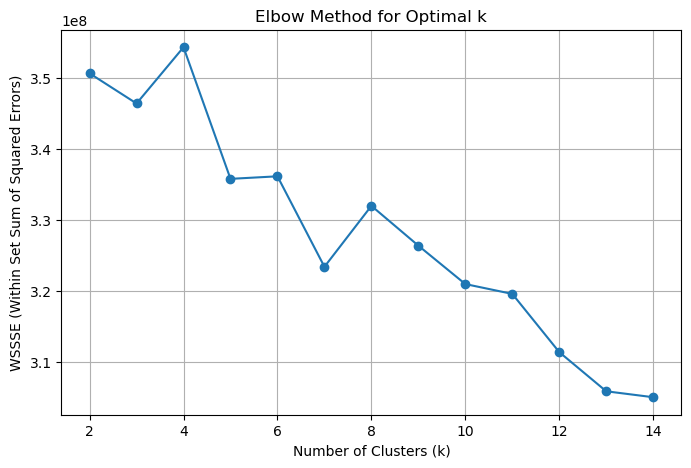

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WSSSE (Within Set Sum of Squared Errors)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [27]:
silhouette_scores = []
k_values = list(range(2, 15))

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol="scaled_features", predictionCol="cluster")
    model = kmeans.fit(scaled_df)
    predictions = model.transform(scaled_df)

    evaluator = ClusteringEvaluator(
        featuresCol="scaled_features",
        predictionCol="cluster",
        metricName="silhouette",
        distanceMeasure="squaredEuclidean"
    )
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)
    print(f"k = {k}, silhouette = {score:.4f}")

k = 2, silhouette = 1.0000


k = 3, silhouette = 0.9999


k = 4, silhouette = 0.7585


k = 5, silhouette = 0.9999


k = 6, silhouette = 0.9988


k = 7, silhouette = 0.9871


k = 8, silhouette = 0.9830


k = 9, silhouette = 0.0689


k = 10, silhouette = 0.0742


k = 11, silhouette = 0.9874


k = 12, silhouette = 0.9876


k = 13, silhouette = 0.0514


k = 14, silhouette = -0.0395


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.grid(True)
plt.show()

**Оптимальное кол-во кластеров**: 5

In [ ]:
spark.stop()